In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.scrna_dataset as scrna_dataset
import model.sdes as sdes
import model.branch_definer as branch_definer
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
samples_per_class = 100

dataset = scrna_dataset.SingleCellDataset(
    "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/processed/covid_flu_processed_reduced_genes.h5"
)

classes = [0, 1, 2, 3, 4, 5, 7, 10, 12]
classes = [0, 1, 5]
inputs_by_class = {}
for c in classes:
    mask = dataset.cell_cluster == c
    inputs = dataset.data[mask]
    sample_inds = torch.tensor(np.random.choice(len(inputs), size=min(samples_per_class, len(inputs)), replace=False))
    inputs_by_class[c] = torch.tensor(inputs[sample_inds]).to(DEVICE)
input_shape = dataset.data.shape[1:]

In [4]:
# Create the diffuser
diffuser = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

### Plotting functions

In [5]:
def plot_forward_diffusion(diffused_inputs_by_class, times):
    """
    Plots the trajectory of the forward-diffusion process.
    Arguments:
        `diffused_inputs_by_class`: the output of
            `branch_definer.run_forward_diffusion`
        `times`: array of times that diffusion was performed at
    """
    # Show distribution over time
    fig, ax = plt.subplots(figsize=(20, 8))
    bins = np.linspace(-4, 4, 1000)
    cmap = plt.get_cmap("magma")
    for t_i in tqdm.notebook.trange(len(times)):
        all_vals = np.concatenate([
            np.random.choice(np.ravel(x[t_i].cpu().numpy()), size=100, replace=False)
            for x in diffused_inputs_by_class.values()
        ])
        ax.hist(all_vals, bins=bins, histtype="step", color=cmap(t_i / len(times)), alpha=0.5, density=True)
    batch_size = next(iter(diffused_inputs_by_class.values())).shape[0]
    prior = diffuser.sample_prior(batch_size, torch.ones(batch_size).to(DEVICE) * times[-1]).cpu().numpy()
    ax.hist(np.ravel(prior), bins=bins, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
    ax.set_xlabel("x")
    ax.set_ylabel("p(x)")
    ax.set_title("Evolution of p(x) over forward SDE")
    ax.set_ylim((0, 3))
    plt.legend()
    plt.show()

In [6]:
def plot_similarities(sim_matrix, classes):
    """
    Plots the similarities between classes.
    Arguments:
        `sim_matrix`: a T x C x C similarity matrix between classes
            at various time points, output by
            `branch_definer.compute_time_similarities`
        `classes`: list of classes matching the order in `sim_matrix`
    """
    # Plot initial pairwise similarities
    labels = np.array(["%s-%s" % (classes[i], classes[j]) for i in range(len(classes)) for j in range(i + 1)])
    sims = np.array([sim_matrix[0, i, j] for i in range(len(classes)) for j in range(i + 1)])
    inds = np.flip(np.argsort(sims))
    labels, sims = labels[inds], sims[inds]
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.bar(labels, sims)
    ax.set_ylabel("Average similarity")
    ax.set_title("Average similarity between pairs of classes (t = 0)")
    plt.show()
                
    # Plot average similarity over time
    mean_sims = []
    triu_inds = np.triu_indices(len(classes))
    for t_i in range(len(sim_matrix)):
        mean_sims.append(np.mean(sim_matrix[t_i][triu_inds]))
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(mean_sims)
    ax.set_xlabel("t")
    ax.set_ylabel("Average similarity")
    ax.set_title("Average similarity over all classes during forward diffusion")
    plt.show()

### Compute branch definitions

Forward-diffusing class 0
Forward-diffusing class 1
Forward-diffusing class 5


  0%|          | 0/1000 [00:00<?, ?it/s]

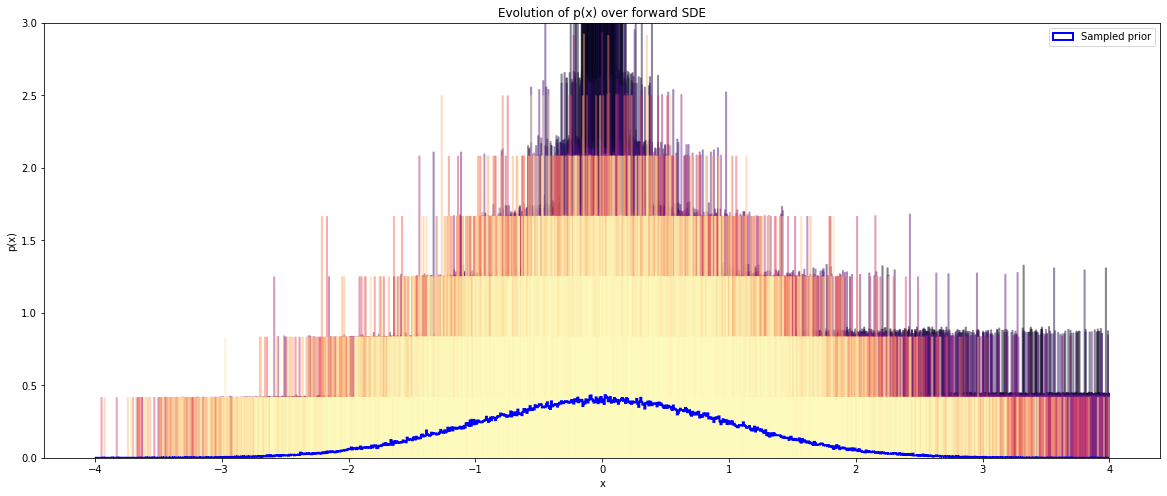

100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1528.96it/s]


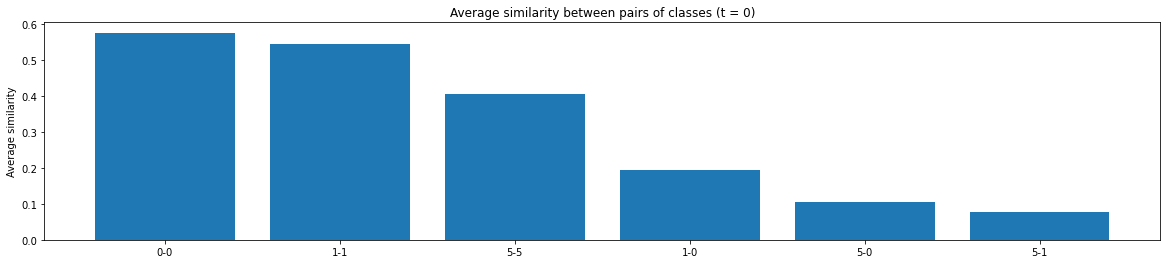

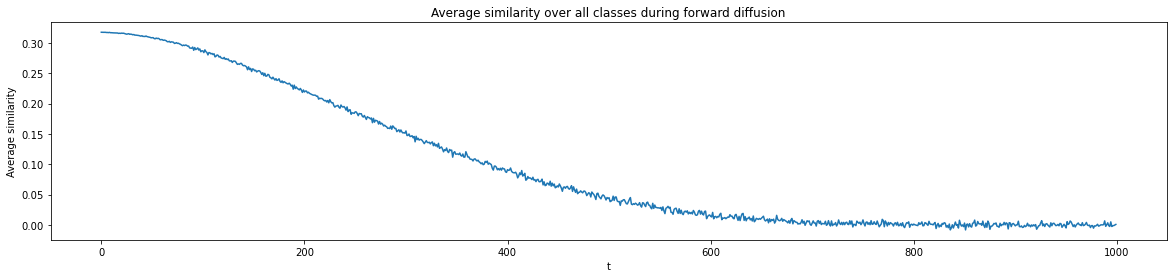

[((0, 1, 5), 6.786786786786787e-01, 1), ((0, 1), 0.5795795795795796, 0.6786786786786787), ((5,), 0, 0.6786786786786787), ((0,), 0, 0.5795795795795796), ((1,), 0, 0.5795795795795796)]


In [7]:
times = np.linspace(0, t_limit, 1000)
diffused_inputs_by_class = branch_definer.run_forward_diffusion(
    inputs_by_class, diffuser, times
)
plot_forward_diffusion(diffused_inputs_by_class, times)
sim_matrix, sim_matrix_classes = branch_definer.compute_time_similarities(diffused_inputs_by_class, times)
plot_similarities(sim_matrix, sim_matrix_classes)
branch_points = branch_definer.compute_branch_points(sim_matrix, times, sim_matrix_classes, epsilon=1e-2)
branch_defs = branch_definer.branch_points_to_branch_defs(branch_points, t_limit)
print(branch_defs)